In [1]:
import numpy as np
np.set_printoptions(precision=3) # only 3 decimals in print
import torch
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf')
from tqdm import tqdm

plt.rc("axes", labelsize = 11)
plt.rc("xtick", labelsize = 10, top = True, direction="in")
plt.rc("ytick", labelsize = 10, right = True, direction="in")
plt.rc("axes", titlesize = 11)
plt.rc("legend", fontsize = 10, loc = "best")
plt.rc('animation', html='jshtml')

In [2]:
def nice_plot(ax):
    ax.set(xlim=[0, 10], ylim=[0, 10], xticks=np.arange(0, 11, 1), yticks=np.arange(0, 11, 1))
    ax.grid(alpha=0.5)

### 7.1 Classification of clusters
This exercise is about establishing a neural network that is capable of classifying 12-atomic Lennard-Jones_Gauss clusters based on a four-dimensional descriptor derived from the cluster coordinates. I.e the network will not require that the elaborate calculation of all interatomic distances is done. To train and test the neural network, a file, `labeled_clusters_1000.txt`, has been prepared and can be found on Brightspace. It contains positions, energies and labels for the clusters. The transformed positions and the raw labels will be used for the training and the testing, while the energies are included merely for plotting purposes.

### 7.2 Load the data
Load positions, energies and labels for 1000 LJG-clusters in 2D

In [3]:
data_flat = np.loadtxt('labeled_clusters_1000.txt')
positions_from_file = data_flat[:,:24].reshape(-1,12,2)
energies_from_file = data_flat[:,24:25].reshape(-1)
labels_from_file = data_flat[:,-1:].reshape(-1).astype('int')

Plot a histogram for all clusters labeled 0, binned according to energy in 1-energy unit intervals. Repeat with new colors for clusters labelled 1 through 9.

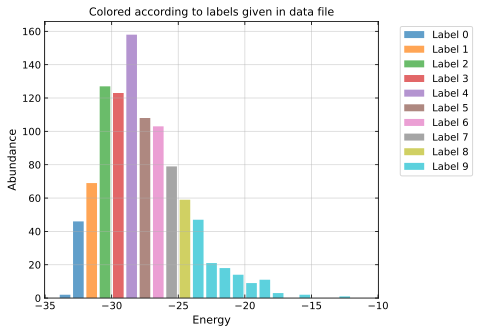

In [4]:
fig, ax = plt.subplots(figsize=(6, 5))

# Binning edges for the histogram
bins = np.arange(-34, -10, 1)  # 1-energy unit intervals

# Loop through labels 0 to 9
for label in range(10):
    # Mask to filter clusters with the current label
    mask = labels_from_file == label
    energies_label = energies_from_file[mask]
    
    # Compute histogram counts
    counts, edges = np.histogram(energies_label, bins=bins)
    
    # Bar widths and positions
    bar_width = edges[1] - edges[0]
    bar_positions = edges[:-1] + bar_width / 2  # Center the bars
    
    # Plot the histogram as bars
    ax.bar(bar_positions, counts, width=0.8*bar_width, alpha=0.7, label=f"Label {label}", color=f'C{label}')

# Add labels and legend
ax.set(xlabel="Energy", ylabel="Abundance", title="Colored according to labels given in data file")
ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
ax.grid(alpha=0.5)

fig.savefig('ex57_fig1.png')

### 7.3 Descriptors
Plot some of the structures and indicate their energies and labels in the titles.

In [5]:
def moment_descriptors(positions, beta=3):
    # Compute the center of mass
    center_of_mass = np.mean(positions, axis=0)  # Shape: (2,)

    # Compute squared distances from the center of mass
    squared_distances = ((positions - center_of_mass) ** 2).sum(axis=1)  # Shape: (N,)

    # Compute the 2nd, 4th, 6th, and 8th moments
    mu2 = beta**-1 * np.sum(squared_distances**1)
    mu4 = beta**-2 * np.sum(squared_distances**2)
    mu6 = beta**-3 * np.sum(squared_distances**3)
    mu8 = beta**-4 * np.sum(squared_distances**4)

    return mu2, mu4, mu6, mu8

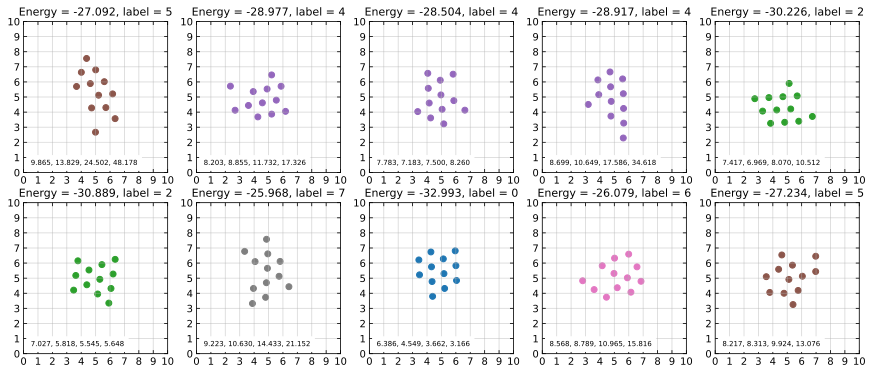

In [6]:
np.random.seed(0)

# Randomly select 10 clusters
np.random.randint(0, len(energies_from_file), 10)

# Plot the selected clusters
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, ax in enumerate(axes.flatten()):
    # Plot the cluster
    ax.scatter(*positions_from_file[i].T, c=f'C{labels_from_file[i]}')
    nice_plot(ax)
    ax.set_title(f'Energy = {energies_from_file[i]:.3f}, label = {labels_from_file[i]}')

    # Calculate moment descriptors
    mu2, mu4, mu6, mu8 = moment_descriptors(positions_from_file[i])
    ax.text(0.05, 0.05, f"{mu2:.3f}, {mu4:.3f}, {mu6:.3f}, {mu8:.3f}", transform=ax.transAxes, ha='left', fontsize=7, backgroundcolor='white')

fig.savefig('ex57_fig2.png')

d) Make an array with the 1000 4-dimensional descriptors, one for each cluster.

In [7]:
# Compute the 4-dimensional descriptors for all clusters
descriptors = np.array([moment_descriptors(cluster) for cluster in positions_from_file])

print(f"Shape of descriptors array: {descriptors.shape}")

Shape of descriptors array: (1000, 4)


### 7.4 Split the data
e) Split the data in 80-10-10 percentage fractions for use as training, validation, and test data, respectively. If you feel like it, plot the three sets as before (remember the energies will not be used by the network).

In [8]:
class Model(torch.nn.Module):
    def __init__(self, n_features=4, n_classes=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, n_classes)
    
    def forward(self, x):
        x = self.fc1(x)
        return x

    def predict_label(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

In [9]:
# Custom Dataset for descriptors and labels
from torch.utils.data import Dataset, DataLoader

class DescriptorDataset(Dataset):
    def __init__(self, descriptors, labels):
        self.descriptors = torch.tensor(descriptors, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.descriptors)

    def __getitem__(self, idx):
        return self.descriptors[idx], self.labels[idx]

In [10]:
# Set random seed for reproducibility
torch.manual_seed(0)

# Total number of data points
n = positions_from_file.shape[0]

# Shuffle indices
indices = torch.randperm(n)

# Define split sizes
n_train = int(0.8 * n)
n_val = int(0.1 * n)
n_test = n - n_train - n_val

# Split indices
train_indices = indices[:n_train]
val_indices = indices[n_train:n_train + n_val]
test_indices = indices[n_train + n_val:]

# Convert descriptors and labels into tensors
descriptors_tensor = torch.tensor(descriptors, dtype=torch.float32)
labels_tensor = torch.tensor(labels_from_file, dtype=torch.long)

# Split data
train_descriptors, val_descriptors, test_descriptors = (
    descriptors_tensor[train_indices],
    descriptors_tensor[val_indices],
    descriptors_tensor[test_indices],
)

train_labels, val_labels, test_labels = (
    labels_tensor[train_indices],
    labels_tensor[val_indices],
    labels_tensor[test_indices],
)

# Create Dataset instances
train_dataset = DescriptorDataset(train_descriptors, train_labels)
val_dataset = DescriptorDataset(val_descriptors, val_labels)
test_dataset = DescriptorDataset(test_descriptors, test_labels)

# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print sizes for verification
print(f"Training set: {len(train_dataset)} samples")
print(f"Validation set: {len(val_dataset)} samples")
print(f"Test set: {len(test_dataset)} samples")


Training set: 800 samples
Validation set: 100 samples
Test set: 100 samples


C:\Users\Jakob\AppData\Local\Temp\ipykernel_5724\682872907.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.descriptors = torch.tensor(descriptors, dtype=torch.float32)
C:\Users\Jakob\AppData\Local\Temp\ipykernel_5724\682872907.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.labels = torch.tensor(labels, dtype=torch.long)


In [11]:
def train_model(model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=100):
    train_losses = []
    val_losses = []

    for epoch in tqdm(range(n_epochs), desc=f'Training {model.__class__.__name__}'):
        model.train()  # Set the model to training mode
        total_loss = 0

        for batch_points, batch_labels in train_dataloader:
            optimizer.zero_grad()  # Zero the gradients

            # Forward pass
            outputs = model(batch_points)

            # Compute loss
            loss = loss_fn(outputs, batch_labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        # Compute average training loss
        avg_train_loss = total_loss / len(train_dataloader)
        train_losses.append(avg_train_loss)

        # Validation loss
        model.eval()
        total_loss = 0

        with torch.no_grad():
            for batch_points, batch_labels in val_dataloader:
                outputs = model(batch_points)
                loss = loss_fn(outputs, batch_labels)
                total_loss += loss.item()

        avg_val_loss = total_loss / len(val_dataloader)
        val_losses.append(avg_val_loss)

    return train_losses, val_losses, model

Training Model: 100%|██████████| 10000/10000 [03:24<00:00, 48.85it/s]


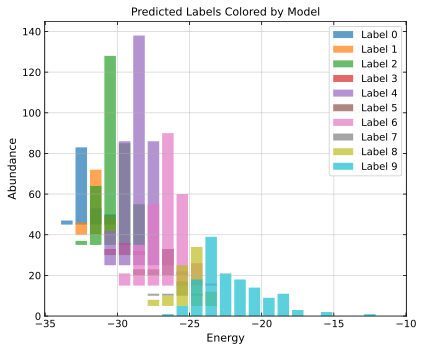

In [12]:
# Instantiate the model, loss function, and optimizer
model = Model(n_features=4, n_classes=10)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
n_epochs = 50
train_losses, val_losses, trained_model = train_model(
    model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=10000
)

# Predict labels for the entire dataset
model.eval()
with torch.no_grad():
    descriptors_tensor = torch.tensor(descriptors, dtype=torch.float32)
    predicted_labels = model.predict_label(descriptors_tensor)

# Plot histogram for predictions binned by energy
fig, ax = plt.subplots(figsize=(6, 5))

# Define bins for energy
bins = np.arange(-34, -10, 1)

# Loop through labels 0 to 9
for label in range(10):
    mask = predicted_labels == label  # Mask for predicted labels
    energies_label = energies_from_file[mask]
    
    # Compute histogram counts
    counts, edges = np.histogram(energies_label, bins=bins)
    
    # Bar widths and positions
    bar_width = edges[1] - edges[0]
    bar_positions = edges[:-1] + bar_width / 2

    # Move bars up to better see overlaps
    bottom = (9-label)*5
    
    # Plot bars
    ax.bar(bar_positions, counts, bottom=bottom, width=0.8 * bar_width, alpha=0.7, label=f"Label {label}", color=f'C{label}')

# Add labels and legend
ax.set(xlabel="Energy", ylabel="Abundance", title="Predicted Labels Colored by Model")
ax.legend()
ax.grid(alpha=0.5)
plt.tight_layout()

fig.savefig('ex57_fig3.png')

### 7.5 Neural networks
Make a couple of neural networks (vary the width and number of hidden layers). They should take 4-dimensional vectors as input and give 10 outputs, one for each label. Train the networks on the training data, and use the validation data to check when to stop the training. Plot the calculated losses, and correlation plots of the true labels (from the file) versus the labels predicted by the networks.

In [13]:
# Neural networks
class Model1(torch.nn.Module):
    def __init__(self, n_features=4, n_classes=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, 64)
        self.fc2 = torch.nn.Linear(64, n_classes)
        self.activation = torch.nn.SiLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x

    def predict_label(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

class Model2(torch.nn.Module):
    def __init__(self, n_features=4, n_classes=10):
        super().__init__()
        self.fc1 = torch.nn.Linear(n_features, 64)
        self.fc2 = torch.nn.Linear(64, 32)
        self.fc3 = torch.nn.Linear(32, n_classes)
        self.activation = torch.nn.SiLU()

    def forward(self, x):
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        x = self.activation(x)
        x = self.fc3(x)
        return x

    def predict_label(self, x):
        x = self.forward(x)
        return torch.argmax(x, dim=1)

Training Model2: 100%|██████████| 10000/10000 [05:26<00:00, 30.65it/s]


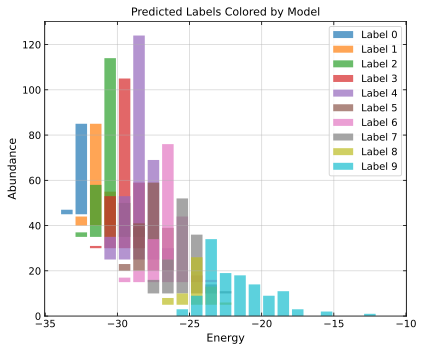

In [14]:
# Instantiate the model, loss function, and optimizer
model = Model2(n_features=4, n_classes=10)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Train the model
n_epochs = 50
train_losses, val_losses, trained_model = train_model(
    model, train_dataloader, val_dataloader, loss_fn, optimizer, n_epochs=10000
)

# Predict labels for the entire dataset
model.eval()
with torch.no_grad():
    descriptors_tensor = torch.tensor(descriptors, dtype=torch.float32)
    predicted_labels = model.predict_label(descriptors_tensor)

# Plot histogram for predictions binned by energy
fig, ax = plt.subplots(figsize=(6, 5))

# Define bins for energy
bins = np.arange(-34, -10, 1)

# Loop through labels 0 to 9
for label in range(10):
    mask = predicted_labels == label  # Mask for predicted labels
    energies_label = energies_from_file[mask]
    
    # Compute histogram counts
    counts, edges = np.histogram(energies_label, bins=bins)
    
    # Bar widths and positions
    bar_width = edges[1] - edges[0]
    bar_positions = edges[:-1] + bar_width / 2

    # Move bars up to better see overlaps
    bottom = (9-label)*5
    
    # Plot bars
    ax.bar(bar_positions, counts, bottom=bottom, width=0.8 * bar_width, alpha=0.7, label=f"Label {label}", color=f'C{label}')

# Add labels and legend
ax.set(xlabel="Energy", ylabel="Abundance", title="Predicted Labels Colored by Model")
ax.legend()
ax.grid(alpha=0.5)
plt.tight_layout()

fig.savefig('ex57_fig4.png')